Enter '1' to predict KSE 100 index or '2' to predict PSX data: 2


<ipython-input-9-d148eb19c31e>:9: UserWarning: Parsing dates in %Y-%m-%dT%H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date', dayfirst=True)


Enter the number of years to predict: 3


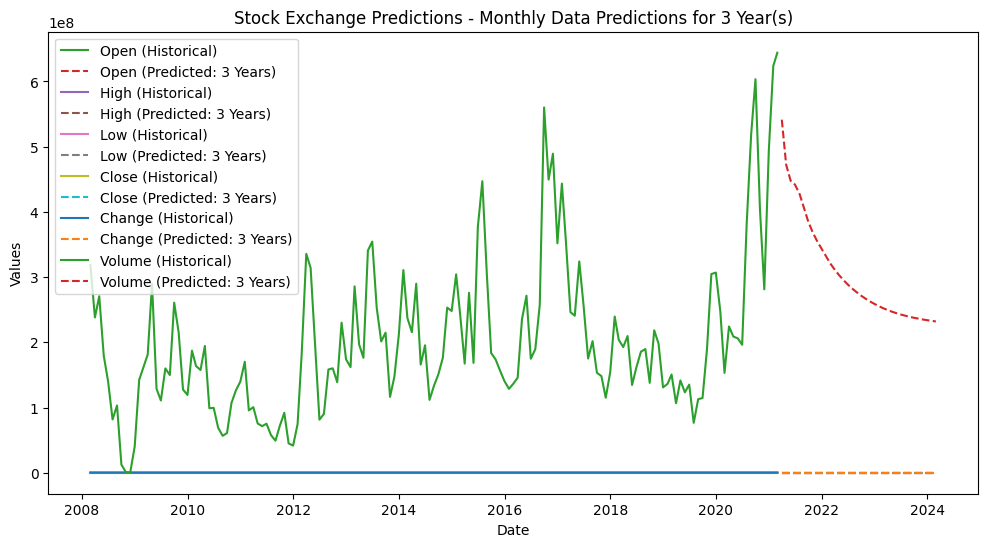

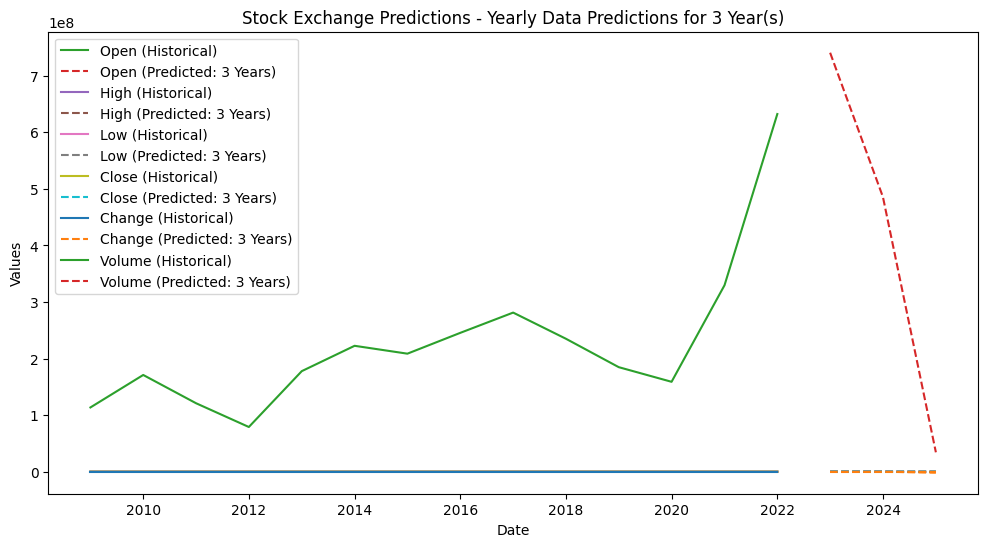

Future Monthly Predictions:
                   _id          Open          High           Low  \
2021-03-31  -11.076331  32074.060126  32195.553897  31891.886248   
2021-04-30  -31.936054  31994.809034  32094.148262  31789.005136   
2021-05-31  -51.926270  31844.648911  31943.998816  31655.906683   
2021-06-30  -72.685635  31838.135646  31941.945693  31670.837457   
2021-07-31  -94.119412  31920.025080  32026.566599  31759.741386   
2021-08-31 -114.774882  32031.844690  32142.612409  31873.178587   
2021-09-30 -135.482395  32155.683105  32267.644029  31991.315869   
2021-10-31 -156.411582  32266.398343  32377.876982  32094.159851   
2021-11-30 -176.872371  32361.011226  32472.005935  32183.596653   
2021-12-31 -197.378122  32447.356738  32557.531049  32266.851222   
2022-01-31 -218.120407  32530.374825  32639.911320  32348.299108   
2022-02-28 -238.696451  32613.840595  32723.048430  32430.818404   
2022-03-31 -259.322696  32699.168708  32808.135357  32514.861763   
2022-04-30 -280.0956

In [ ]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import os

def load_and_clean_data(file_path):
    try:
        data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date', dayfirst=True)
        for col in ['Open', 'High', 'Low', 'Close', 'Change', 'Volume']:
            if col in data.columns:
                data[col] = pd.to_numeric(data[col].str.replace(',', ''), errors='coerce')
        data.fillna(method='ffill', inplace=True)
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        exit()

# User choice for dataset
choice = input("Enter '1' to predict KSE 100 index or '2' to predict PSX data: ")

if choice == '1':
    file_path = 'Stock Exchange KSE 100(Pakistan).csv'
elif choice == '2':
    file_path = 'PSX.csv.csv'
else:
    print("Invalid choice. Please restart and enter '1' or '2'.")
    exit()

# Check if the file exists
if not os.path.isfile(file_path):
    print(f"File not found: {file_path}")
    exit()

data = load_and_clean_data(file_path)

# Resample the data to monthly and yearly frequencies
monthly_data = data.resample('M').mean()
yearly_data = data.resample('Y').mean()

# Define a function to fit the model and make predictions
def fit_and_predict(series, periods):
    model = AutoReg(series, lags=5)
    model_fit = model.fit()
    end_index = len(series) + periods - 1
    predictions = model_fit.predict(start=len(series), end=end_index, dynamic=False)
    return predictions

# Define function to predict future data for variable number of years
def predict_future(data, freq, years):
    prediction_period = years * (12 if freq == 'M' else 1)
    predictions = {}
    for col in data.columns:
        predictions[col] = fit_and_predict(data[col], prediction_period)

    future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1 if freq == 'M' else 1), periods=prediction_period, freq=freq)
    future_data = pd.DataFrame(predictions, index=future_dates)
    return future_data

# Add profit/loss column to predictions
def add_profit_loss_column(data):
    data['Profit/Loss'] = (data['Close'].diff().fillna(0) > 0).replace({True: 'Profit', False: 'Loss'})
    return data

# Accept input for number of years to predict
years_to_predict = int(input("Enter the number of years to predict: "))

# Perform predictions and save results
future_monthly_data = predict_future(monthly_data, 'M', years_to_predict)
future_yearly_data = predict_future(yearly_data, 'Y', years_to_predict)

# Add profit/loss column
future_monthly_data = add_profit_loss_column(future_monthly_data)
future_yearly_data = add_profit_loss_column(future_yearly_data)

# Identify the best month and volume to invest in
def identify_best_investment(data):
    best_month = data[data['Profit/Loss'] == 'Profit']['Close'].idxmax()
    best_volume = data.loc[best_month, 'Volume']
    return best_month, best_volume

best_monthly_investment, best_monthly_volume = identify_best_investment(future_monthly_data)

# Plot the results for monthly predictions
plt.figure(figsize=(12, 6))
for col in monthly_data.columns:
    plt.plot(monthly_data.index, monthly_data[col], label=f'{col} (Historical)')
    plt.plot(future_monthly_data.index, future_monthly_data[col], label=f'{col} (Predicted: {years_to_predict} Years)', linestyle='--')
plt.title(f'Stock Exchange Predictions - Monthly Data Predictions for {years_to_predict} Year(s)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.savefig(f'Future_Monthly_Predictions_{years_to_predict}_years.png')  # Save plot as PNG
plt.show()

# Plot the results for yearly predictions
plt.figure(figsize=(12, 6))
for col in yearly_data.columns:
    plt.plot(yearly_data.index, yearly_data[col], label=f'{col} (Historical)')
    plt.plot(future_yearly_data.index, future_yearly_data[col], label=f'{col} (Predicted: {years_to_predict} Years)', linestyle='--')
plt.title(f'Stock Exchange Predictions - Yearly Data Predictions for {years_to_predict} Year(s)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.savefig(f'Future_Yearly_Predictions_{years_to_predict}_years.png')  # Save plot as PNG
plt.show()

# Save predictions to CSV files
future_monthly_data.to_csv(f'Future_Monthly_Predictions_{years_to_predict}_years.csv')
future_yearly_data.to_csv(f'Future_Yearly_Predictions_{years_to_predict}_years.csv')

# Print predicted values
pd.set_option('display.max_columns', None)
print("Future Monthly Predictions:")
print(future_monthly_data)
print("\nFuture Yearly Predictions:")
print(future_yearly_data)

# Suggest best month and volume to invest
print(f"\nBest month to invest: {best_monthly_investment.strftime('%Y-%m')}")
print(f"Suggested volume to invest in that month: {best_monthly_volume}")
